In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn.datasets import fetch_atlas_schaefer_2018
from neuromaps.parcellate import Parcellater
from netneurotools import datasets, plotting
from scipy.stats import zscore, spearmanr
import pyvista as pv
import matplotlib.cm as cm
import matplotlib.pyplot as plt



In [2]:
def plot_subcortex(data, atlas_rois, hemi_labels, cmap="plasma",
                   vmin=None, vmax=None, outpath=None):

    assert len(data) == len(atlas_rois), \
        "Data length must match number of ROIs"

    views = {
        "Right Lateral": ("zy", (0, 0, -1)),
        "Left Lateral": ("yz", (0, 0, -1)),
        "Right Medial": ("yz", (0, 0, -1)),
        "Left Medial": ("zy", (0, 0, -1)),
    }

    plotters = []
    for view_name, (cam_pos, up_dir) in views.items():
        hemi = 'R' if 'Right' in view_name else 'L'
        pl = pv.Plotter(off_screen=True, window_size=(512, 512))
        for i, (roi, hem) in enumerate(zip(atlas_rois, hemi_labels)):
            if hem != hemi:
                continue
            color = cm.get_cmap(cmap)((data[i] - (vmin or np.min(data))) /
                                      ((vmax or np.max(data))
                                       - (vmin or np.min(data))))
            if np.isnan(data[i]):
                color = [0.7, 0.7, 0.7]
            pl.add_mesh(roi, color=color[:3])
        pl.camera_position = cam_pos
        pl.camera.up = up_dir
        plotters.append(pl)

    # Render all views and combine into 2x2 panel
    imgs = [pl.screenshot(return_img=True) for pl in plotters]
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.ravel()
    for ax, img, title in zip(axs, imgs, views.keys()):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()

    if outpath is not None:
        plt.savefig(outpath)

In [3]:
path = "/Users/laurituominen/Documents/Research/test_neuromaps_subcortex"
smoke_file = path + '/data/smoking_pctdiff.nii.gz'


In [4]:
parcellater_tian = Parcellater(path + '/atlas/Tian_Subcortex_S4_3T_1mm.nii.gz',
                               'MNI152')
with open(path+'/atlas/Tian_Subcortex_S4_3T_label.txt', 'r') as f:
    tianlabels = [line.strip() for line in f]


smoking = parcellater_tian.fit_transform(smoke_file,
                                            'MNI152', True).squeeze()

/var/folders/ft/yby1tt_573g4_h62k4ny40d00000gn/T/ipykernel_94534/3630388541.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap(cmap)((data[i] - (vmin or np.min(data))) /


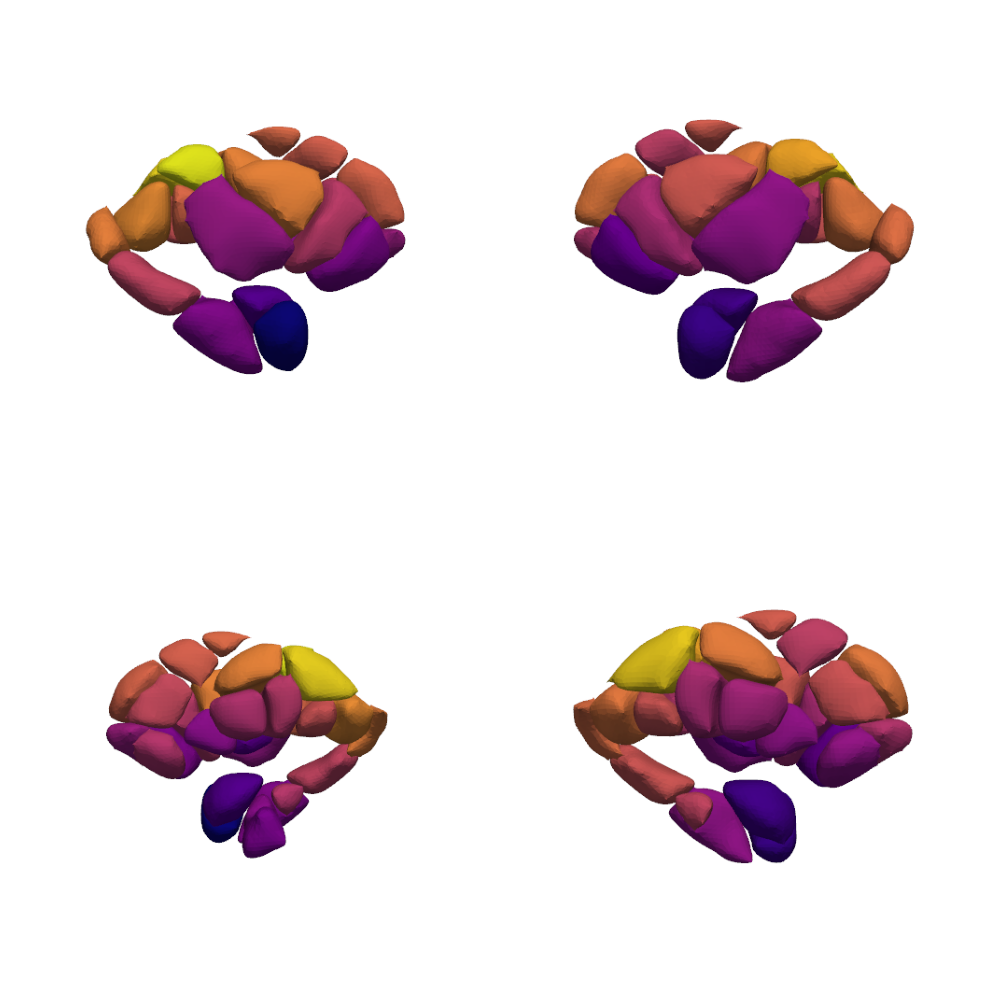

In [6]:
atlas = pv.read(path+'/atlas/Tian_Subcortex_S4_3T_1mm.nii.gz')
atlas_rois = [atlas.image_threshold([i, i]).contour(
    [1]).smooth_taubin(n_iter=25, pass_band=0.01, non_manifold_smoothing=True)
              for i in range(1, 55)]
hemi_labels = ['R' if i < 28 else 'L' for i in range(len(atlas_rois))]

plot_subcortex(smoking, atlas_rois, hemi_labels, cmap="plasma",
               vmin=smoking.min(), vmax=smoking.max(),
               outpath=path+'/figures/smoking_subcortex.png')
